# Fast Training of Support Vector Machines for Survival Analysis

This document demonstrates how to use the efficient implementation of *Survival Support Vector Machines* as proposed in

> Pölsterl, S., Navab, N., and Katouzian, A.,
> *Fast Training of Support Vector Machines for Survival Analysis*,
> In Proceedings of the European Conference on Machine Learning and
> Principles and Practice of Knowledge Discovery in Databases (ECML PKDD), 2015

The source code and installation instructions are available at https://github.com/tum-camp/survival-support-vector-machine.

The main class of interest is ``survival.svm.FastSurvivalSVM``, which implements the different optimizers for training
a Survival Support Vector Machine. Training data consists of $n$ triplets $(\mathbf{x}_i, y_i, \delta_i)$, where
$\mathbf{x}_i$ is a $d$-dimensional feature vector, $y_i > 0$ the survival time or time of censoring, and $\delta_i \in \{0,1\}$ the binary event indicator. Using the training data, the objective is to minimize the following function:

\begin{equation}
 \arg \min_{\mathbf{w}, b} \frac{1}{2} \mathbf{w}^T \mathbf{w}+ \frac{\alpha}{2} \left[
 r \sum_{i,j \in \mathcal{P}}
  \max(0, 1 - (\mathbf{w}^T \mathbf{x}_i - \mathbf{w}^T \mathbf{x}_j))^2
+ (1 - r) \sum_{i=0}^n \left( \zeta_{\mathbf{w},b} (y_i, x_i, \delta_i) \right)^2
\right]
\end{equation}

\begin{equation}
\zeta_{\mathbf{w},b} (y_i, \mathbf{x}_i, \delta_i) =
\begin{cases}
  \max(0, y_i - \mathbf{w}^T \mathbf{x}_i - b) & \text{if $\delta_i = 0$,} \\
 y_i - \mathbf{w}^T \mathbf{x}_i - b & \text{if $\delta_i = 1$,} \\
\end{cases}
\end{equation}

\begin{equation}
\mathcal{P} = \{ (i, j)~|~y_i > y_j \land \delta_j = 1 \}_{i,j=1,\dots,n}
\end{equation}

The hyper-parameter $\alpha > 0$ determines the amount of regularization to apply: a smaller value increases the amount of regularization and a higher value reduces the amount of regularization. The hyper-parameter $r \in [0; 1]$ determines the trade-off between the ranking objective and the regresson objective. If $r = 1$ it reduces to the ranking objective, and if $r = 0$ to the regression objective. If the regression objective is used, it is advised to log-transform the survival/censoring time first.

In this example, I'm going to use the ranking objective ($r = 1$) and grid search to determine the best setting for the hyper-parameter $\alpha$.

The class ``survival.svm.FastSurvivalSVM`` adheres to interfaces used in [scikit-learn](http://scikit-learn.org) and thus it is possible to combine it with auxiliary classes and functions from scikit-learn. Here, I'm going to use [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html#sklearn.grid_search.GridSearchCV) to determine which set hyper-parameters performs best for the Veteran's Lung Cancer data. Since, we require an event indicator $\delta_i$, which is boolean, and the survival/censoring time $y_i$ for training, we have to create a structured array that contains both information.

But first, we have to import the classes we are going to use.

In [1]:
import sys
sys.path.insert(0, "/home/sebp/Projekte/survival-support-vector-machine/")

In [2]:
%cd ..
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas
import seaborn as sns
from sklearn.cross_validation import ShuffleSplit
from sklearn.grid_search import GridSearchCV

from survival.column import categorical_to_numeric, standardize
from survival.io import loadarff
from survival.metrics import concordance_index_censored
from survival.svm import FastSurvivalSVM

/home/sebp/Projekte/survival-support-vector-machine


/home/sebp/miniconda3/envs/ssvm/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Next, load data of the *Veteran's Administration Lung Cancer Trial* from disk and convert it to numeric values. The data consists of 137 patients and 6 features. The  primary  outcome  measure  was  death (`Status`, `Survival_in_days`).
The original data can be retrieved from http://lib.stat.cmu.edu/datasets/veteran.

Note that it does not matter how you name the fields corresponding to the event indicator and time, as long as the event indicator comes first.

In [3]:
data = loadarff("data/veteran.arff")
x = categorical_to_numeric(standardize(data.drop(["Status", "Survival_in_days"], axis=1)))
y = np.empty(dtype=[("event", bool), ("time", float)], shape=data.shape[0])
y["event"] = (data["Status"] == "'dead'").values
y["time"] = data["Survival_in_days"].values

Now, we are essentially ready to start training, but before let's determine what the amount of censoring for this data is and plot the survival/censoring times.

In [4]:
n_censored = y.shape[0] - y["event"].sum()
print("%.1f%% of records are censored" % (n_censored / y.shape[0] * 100))

6.6% of records are censored


/home/sebp/miniconda3/envs/ssvm/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.
  from ipykernel import kernelapp as app


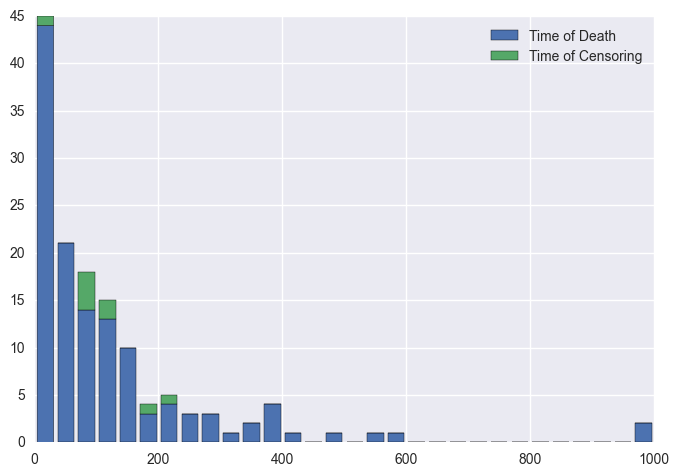

In [5]:
val, bins, patches = plt.hist((y["time"][y["event"]],
                               y["time"][-y["event"]]),
                              bins=30, stacked=True)
plt.legend(patches, ["Time of Death", "Time of Censoring"])

First, we need to create an initial model with default parameters that is subsequently used in the grid search. We are going to use a Red-Black tree to speed up optimization.

In [6]:
estimator = FastSurvivalSVM(optimizer="rbtree", max_iter=1000, tol=1e-6, random_state=0)

Next, we define a function for evaluating the performance of models during grid search. We use Harrell's concordance index.

In [7]:
def score_survival_model(model, X, y):
    prediction = model.predict(X)
    result = concordance_index_censored(y['event'], y['time'], prediction)
    return result[0]

The last part of the setup specifies the set of parameters we want to try and how many repetitions of training and testing we want to perform for each parameter setting. In the end, the parameters that on average peformed best across all test sets (200 in this case) are selected. [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html#sklearn.grid_search.GridSearchCV) can leverage multiple cores by evaluating multiple parameter settings concurrently (I use 4 jobs in this example).

In [8]:
param_grid = {'alpha': 2. ** np.arange(-12, 13, 2)}
cv = ShuffleSplit(x.shape[0], n_iter=200, train_size=0.5, random_state=0)
gcv = GridSearchCV(estimator, param_grid, score_survival_model, cv=cv,
                   n_jobs=4, iid=False, refit=False)

Finally, start the hyper-parameter search. This can take a while since a total of ``13 * 200 = 2600`` fits have to be evaluated.

In [9]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
gcv = gcv.fit(x, y)

Let's check what is the best average performance across 200 random train/test splits we got and the corresponding hyper-parameters.

In [10]:
gcv.best_score_, gcv.best_params_

(0.6932455298137199, {'alpha': 0.0009765625})

Finally, we retrieve all 200 test scores for each parameter setting and visualize their distribution by box plots.

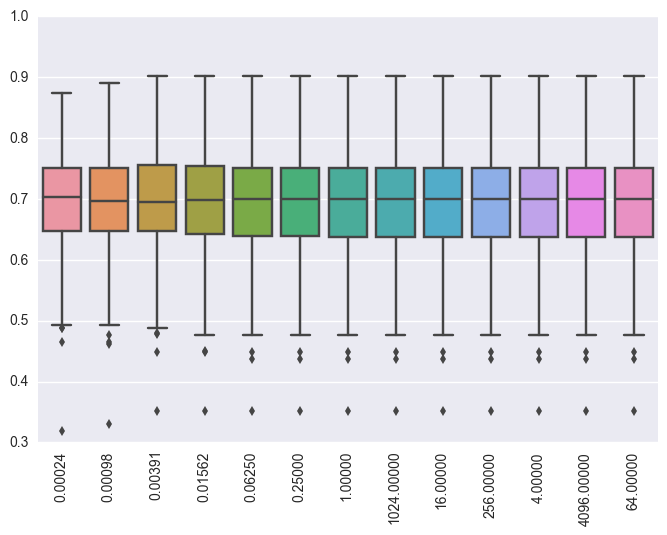

In [11]:
cv_scores = {}
for i in range(len(gcv.grid_scores_)):
    v = gcv.grid_scores_[i]
    name = "%.5f" % v.parameters["alpha"]
    cv_scores[name] = v.cv_validation_scores

sns.boxplot(pandas.DataFrame(cv_scores))
_, xtext = plt.xticks()
for t in xtext:
    t.set_rotation("vertical")